In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from logging import basicConfig, getLogger, DEBUG
import warnings
from typing import List, Dict, Tuple
from itertools import chain
import pickle
from collections import defaultdict, Counter
from pprint import pprint

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# from catalyst import metrics
from catalyst import dl, utils
from catalyst.data import ToTensor

warnings.simplefilter('ignore')

# basicConfig(level=DEBUG)
# logger = getLogger(__name__)

In [2]:
normal_file_raw = os.path.join("../", "dataset", "csic2010","normalTrafficTraining.txt")
anomaly_file_raw = os.path.join("../", "dataset", "csic2010","anomalousTrafficTest.txt")
normal_file_parse = os.path.join("../", "dataset", "csic2010","normalRequestTraining.txt")
anomaly_file_parse = os.path.join("../", "dataset", "csic2010","anomalousRequestTest.txt")

In [3]:
import io
import urllib.parse

def parse_file(file_in, file_out):
    fin = open(file_in)
    fout = io.open(file_out, "w", encoding="utf-8")
    lines = fin.readlines()
    res = []
    for i in range(len(lines)):
        line = lines[i].strip()
        if line.startswith("GET"):
            res.append("GET" + line.split(" ")[1])
        elif line.startswith("POST") or line.startswith("PUT"):
            url = line.split(' ')[0] + line.split(' ')[1]
            j = 1
            while True:
                if lines[i + j].startswith("Content-Length"):
                    break
                j += 1
            j += 1
            data = lines[i + j + 1].strip()
            url += '?' + data
            res.append(url)
    for line in res:
        line = urllib.parse.unquote(line).replace('\n','').lower()
        fout.writelines(line + '\n')
        
    print ("finished parse ",len(res)," requests")
    fout.close()
    fin.close()
    
def loadData(file):
    with open(file, 'r', encoding="utf8") as f:
        data = f.readlines()
    result = []
    for d in data:
        d = d.strip()
        if (len(d) > 0):
            result.append(d)
    return result

In [7]:
parse_file(normal_file_raw,normal_file_parse)
parse_file(anomaly_file_raw,anomaly_file_parse)

finished parse  36000  requests
finished parse  25065  requests


In [4]:
bad_requests = loadData(anomaly_file_parse)
good_requests = loadData(normal_file_parse)

In [47]:
bad_requests

["gethttp://localhost:8080/tienda1/publico/anadir.jsp?id=2&nombre=jam�n+ib�rico&precio=85&cantidad=';+drop+table+usuarios;+select+*+from+datos+where+nombre+like+'%&b1=a�adir+al+carrito",
 "posthttp://localhost:8080/tienda1/publico/anadir.jsp?id=2&nombre=jam�n+ib�rico&precio=85&cantidad=';+drop+table+usuarios;+select+*+from+datos+where+nombre+like+'%&b1=a�adir+al+carrito",
 'gethttp://localhost:8080/tienda1/publico/anadir.jsp?id=2/&nombre=jam�n+ib�rico&precio=85&cantidad=49&b1=a�adir+al+carrito',
 'posthttp://localhost:8080/tienda1/publico/anadir.jsp?id=2/&nombre=jam�n+ib�rico&precio=85&cantidad=49&b1=a�adir+al+carrito',
 'gethttp://localhost:8080/asf-logo-wide.gif~',
 'gethttp://localhost:8080/tienda1/publico/autenticar.jsp?modo=entrar&login=bob@<script>alert(paros)</script>.parosproxy.org&pwd=84m3ri156&remember=on&b1=entrar',
 'posthttp://localhost:8080/tienda1/publico/autenticar.jsp?modo=entrar&login=bob@<script>alert(paros)</script>.parosproxy.org&pwd=84m3ri156&remember=on&b1=entrar

In [34]:
X = np.array(bad_requests + good_requests)
yBad = [1] * len(bad_requests)
yGood = [0] * len(good_requests)
y = yBad + yGood

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

In [36]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (48852,)
X_test shape: (12213,)


In [33]:
# vectorizer = TfidfVectorizer(min_df=0.0, analyzer="char", sublinear_tf=True, ngram_range=(3, 3))
vectorizer = CountVectorizer(min_df=0.0, analyzer="char", ngram_range=(3, 3))
X = vectorizer.fit_transform(all_requests)
vectorizer.get_feature_names()

NameError: name 'all_requests' is not defined

In [37]:
# vectorizer = TfidfVectorizer(min_df=0.0, analyzer="char", sublinear_tf=True, ngram_range=(3, 3))
vectorizer = CountVectorizer(min_df=0.0, analyzer="char", ngram_range=(3, 3))
vectorizer.fit(X_train)

CountVectorizer(analyzer='char', min_df=0.0, ngram_range=(3, 3))

In [38]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [39]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (48852, 28573)
X_test shape: (12213, 28573)


In [45]:
X_train[:100].toarray().sum()

10642

In [41]:
#logistic regression
lgs = LogisticRegression()
lgs.fit(X_train, y_train)
y_pred = lgs.predict(X_test)
score_test = metrics.accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print ("Score Logistic Regression :",score_test)
print ("Confusion Matrix: ")
print (matrix)

Score Logistic Regression : 0.9902562842872349
Confusion Matrix: 
[[7216   32]
 [  87 4878]]


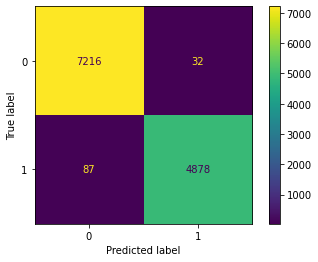

In [42]:
metrics.plot_confusion_matrix(lgs, X_test, y_test)
plt.show()

In [43]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7248
           1       0.99      0.98      0.99      4965

    accuracy                           0.99     12213
   macro avg       0.99      0.99      0.99     12213
weighted avg       0.99      0.99      0.99     12213

